In [6]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.ndimage as ndi
from sklearn.cluster import KMeans


In [7]:
root = os.getcwd()
print(root)
# img_path = os.path.join(root, "/23-10-images/Lctorica01.tif")
img_gray = cv.imread("./../images/ConicaExp.tif", cv.IMREAD_GRAYSCALE)

c:\Users\PC\Desktop\UN\OpticsWork\codefiles\thesisreproduction\29-10-tests\codefiles


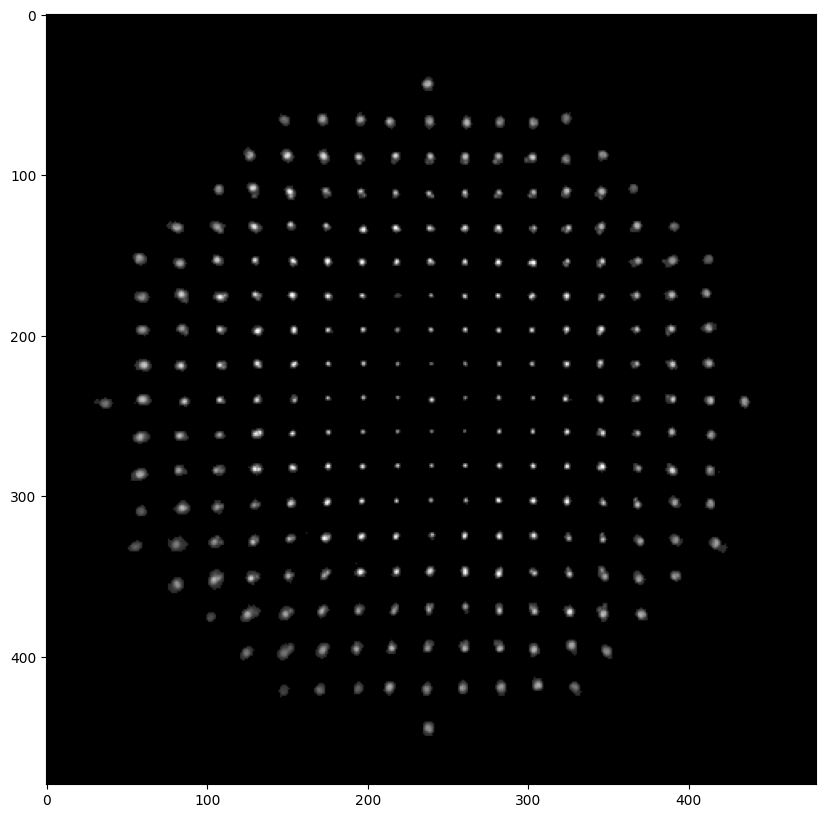

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(img_gray, cmap="gray")


Successfully loaded image 'c:\Users\PC\Desktop\UN\OpticsWork\codefiles\thesisreproduction\29-10-tests\codefiles\./../images/ConicaExp.tif' with shape (480, 480)
Created binary mask with threshold=50.
[146  63   6   6  29]
Found 255 total blobs (including noise).

Smallest real spot (Blob #253) has 3 pixels.
Largest noise blob (Blob #254) has 1 pixels.
--- Automatically setting min_spot_size to: 2 ---
Kept 253 spots after filtering.
Calculated 253 precise sub-pixel centroids.
Sorted all centroids correctly using column clustering.
Successfully saved 253 precise, sorted centroids to ./../data/29-10-conica-centroids.txt


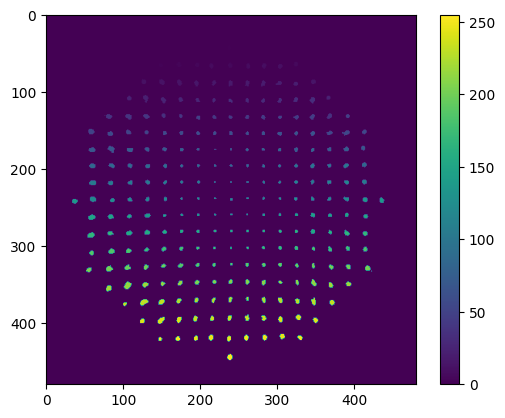

In [9]:
threshold_value = 50

expected_spots = 253
number_of_columns = 19

output_filename = './../data/29-10-conica-centroids.txt'

# --- 2. Load the Image ---
root = os.getcwd()
img_path = os.path.join(root, "./../images/ConicaExp.tif")
img_gray = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

if img_gray is None:
    print(f"Error: Could not load image '{img_path}'.")
else:
    print(f"Successfully loaded image '{img_path}' with shape {img_gray.shape}")

    # --- 3. Isolate the Spots (Get Binary Mask) ---
    ret, binary_mask = cv.threshold(img_gray, threshold_value, 255, cv.THRESH_BINARY)
    print(f"Created binary mask with threshold={threshold_value}.")

    # --- 4. Find and Label All Spots (with Stats) ---
    num_labels, labels_matrix, stats, centroids = cv.connectedComponentsWithStats(binary_mask)
    
    plt.imshow(labels_matrix)
    plt.colorbar()

    print(stats[2, :])

    # Get the size (area) of all blobs, skipping the background (label 0)
    all_blob_sizes = stats[1:, cv.CC_STAT_AREA]
    # Here, it orders from the biggest to the smallest one
    all_blob_sizes_sorted = sorted(all_blob_sizes, reverse=True)
    
    print(f"Found {len(all_blob_sizes_sorted)} total blobs (including noise).")

    # --- 5. AUTOMATICALLY Find the 'min_spot_size' ---
    # (This is the "diagnostic" code, now integrated)
    
    if len(all_blob_sizes_sorted) < expected_spots:
        print("\n*** ERROR: Found fewer than {expected_spots} spots. ***")
        print("*** Try lowering the 'threshold_value' (e.g., to 50 or 40) and run again. ***")
    else:
        # This is the size of your smallest "real" spot
        size_of_last_spot = all_blob_sizes_sorted[expected_spots - 1] # Index 252 is the 253rd item
        
        # This is the size of the largest "noise" blob
        size_of_first_noise = all_blob_sizes_sorted[expected_spots]   # Index 253 is the 254th item
        
        # We automatically set the minimum size to be halfway between them
        min_spot_size = (size_of_last_spot + size_of_first_noise) / 2
        
        print(f"\nSmallest real spot (Blob #{expected_spots}) has {size_of_last_spot} pixels.")
        print(f"Largest noise blob (Blob #{expected_spots + 1}) has {size_of_first_noise} pixels.")
        print(f"--- Automatically setting min_spot_size to: {int(min_spot_size)} ---")

        # --- 6. Filter out Noise ---
        valid_indices = []
        for label_id in range(1, num_labels): # Loop from 1 (skip background 0)
            if stats[label_id, cv.CC_STAT_AREA] > min_spot_size:
                valid_indices.append(label_id)
                
        print(f"Kept {len(valid_indices)} spots after filtering.")

        # --- 7. Calculate Precise Intensity-Weighted Centroids ---
        precise_centroids_yx = ndi.center_of_mass(img_gray, labels=labels_matrix, index=valid_indices)
        print(f"Calculated {len(precise_centroids_yx)} precise sub-pixel centroids.")

        # --- 8. Organize Centroids with Clustering ---
        centroids_xy = [(coord[1], coord[0]) for coord in precise_centroids_yx]
        
        # Prepare data for clustering
        x_coords = np.array([c[0] for c in centroids_xy]).reshape(-1, 1)

        # Check if we have enough points to cluster
        if len(x_coords) < number_of_columns:
            print(f"\n*** ERROR: Not enough spots ({len(x_coords)}) to create {number_of_columns} columns. ***")
            print("*** Your 'min_spot_size' might be too high or 'threshold_value' is wrong. ***")
        else:
            # Initialize and run KMeans to group spots into columns
            kmeans = KMeans(n_clusters=number_of_columns, n_init=10, random_state=0)
            column_labels = kmeans.fit_predict(x_coords)
            
            # Get the X-coordinate of each cluster center
            cluster_centers = kmeans.cluster_centers_.flatten()
            
            # Get the sorted order of the clusters
            cluster_sort_order = np.argsort(cluster_centers)
            
            # Create a map: {original_cluster_id: sorted_column_label}
            cluster_map = {original_id: sorted_id for sorted_id, original_id in enumerate(cluster_sort_order)}

            # Create a new list we can sort properly
            sortable_list = []
            for i in range(len(centroids_xy)):
                spot_xy = centroids_xy[i]
                original_cluster_id = column_labels[i]
                sorted_column_label = cluster_map[original_cluster_id]
                y_coord = spot_xy[1]
                sort_key = (sorted_column_label, y_coord)
                sortable_list.append( (sort_key, spot_xy) )

            # Sort the list based on the key (column, then y)
            sorted_list_of_tuples = sorted(sortable_list, key=lambda item: item[0])
            
            # Extract just the (x, y) coordinates, now in the perfect order
            sorted_centroids = [item[1] for item in sorted_list_of_tuples]

            print("Sorted all centroids correctly using column clustering.")

            # --- 9. Save to File ---
            with open(output_filename, 'w') as f:
                for i, (x_coord, y_coord) in enumerate(sorted_centroids):
                    label = i + 1
                    # Save in the format: label X_float Y_float
                    f.write(f"{label} {x_coord:.8f} {y_coord:.8f}\n")

            print(f"Successfully saved {len(sorted_centroids)} precise, sorted centroids to {output_filename}")